In [8]:
# Importing the usual libraries 
import pandas as pd
import numpy as np

# importing layers
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, model_from_json, Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Saving variables that will be called upon throughout the notebook 
classes = 3 
pixels = 256
channels = 3 #if 3 'color_mode="rgb"', if 1 'color_mode="grayscale"'
path = ''
batch_size = 64

# Training the model for a minimum of 12 and maximum of 30 epochs
min_epochs=12
epochs=64

# Initialize the model 
model = keras.models.Sequential()

In [10]:
# Import the pretrained VGG16 network, do not include the top layers
# Import the architecture with the weights by ='imagenet'
pretrained = InceptionV3(weights='imagenet', include_top=False, pooling='max', input_shape=(pixels,pixels,channels))
# Setting the first few layers to not trainable so weights wont be tweaked
for layer in pretrained.layers[:len(pretrained.layers)-75]:
    layer.trainable=False
# Allow all other layers to be trained on the RPS images    
#for layer in pretrained.layers[153:155]:
    #layer.trainable=True
    
# Display VGG16 architecture
pretrained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 127, 127, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 127, 127, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [11]:
print("Number of layers in the base model: ", len(pretrained.layers))

Number of layers in the base model:  312


In [12]:
# Adding VGG16 to the model
model.add(pretrained)
# Adding additional dense layers
model.add(keras.layers.Dropout(0.5))
model.add(Dense(1028))
model.add(Dense(512))
model.add(Dense(256))
model.add(Dense(classes, activation='softmax'))


# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1028)              2106372   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               526848    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 24,568,103
Trainable params: 14,765,831
Non-trainable params: 9,802,272
__________________________________

In [14]:
# Istantiating the training/validation ImageDataGenerator()
datagen_train = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   rotation_range=0,
                                   width_shift_range=[-15,15],
                                   height_shift_range=[-15,15],
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                   fill_mode='reflect',
                                   validation_split=0.2)

# Istantiating the test generator
datagen_test = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  rotation_range=0,
                                  width_shift_range=[-15,15],
                                  height_shift_range=[-15,15],
                                  zoom_range=0.1,
                                  shear_range=0.2,
                                  fill_mode='reflect'
                                  )

In [15]:
# The generator for the training data, shuffle set to True 
# (unable to view confusion matrix and classification report as a result)
train_generator = datagen_train.flow_from_directory(r'D:\Sina\KNTU\MSc\4th Semester\Courses\AIES\Projects\ANN Project\Part2\train',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True, subset='training')

# Generator for validation data, shuffle set to 'False' to allow for model evaluation
validation_generator = datagen_train.flow_from_directory(r'D:\Sina\KNTU\MSc\4th Semester\Courses\AIES\Projects\ANN Project\Part2\train',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False, subset='validation')

# Generator for test data, shuffle set to 'False' to allow for model evaluation
test_generator = datagen_test.flow_from_directory(r'D:\Sina\KNTU\MSc\4th Semester\Courses\AIES\Projects\ANN Project\Part2\test',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 690 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Found 95 images belonging to 3 classes.


In [16]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.n//train_generator.batch_size + 1
valid_stepsize = validation_generator.samples//validation_generator.batch_size + 1
test_stepsize = test_generator.samples//test_generator.batch_size + 1

# Sanity check 
print(f'Training step size = {train_stepsize}, Validation step size = {valid_stepsize}')
print(f'Test step size = {test_stepsize}')

Training step size = 11, Validation step size = 3
Test step size = 2


In [17]:
# Early stopping will help prevent overfitting the model to the train data, 
# Initiate early stop based on validation accuracy
# Will not stop before 'min_epochs' of 12 (patience)
ES = EarlyStopping(monitor='val_accuracy', mode='auto', min_delta=0, patience=min_epochs, verbose=1)

# Model checkpointer that will only save the weights from the epoch with the best validation accuracy
checkpoint = ModelCheckpoint("best_weights_vgg16.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


# Adding both callbacks to a 'callbacks_list'
callbacks_list = [ES, checkpoint]    

In [18]:
# Fitting the model to the training data
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=epochs,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=callbacks_list)

C:\Users\Sina\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/64
11/11 [==============================] - 132s 8s/step - loss: 4.5664 - accuracy: 0.6060 - val_loss: 3.7691 - val_accuracy: 0.7719

Epoch 00001: val_accuracy improved from -inf to 0.77193, saving model to best_weights_vgg16.h5
Epoch 2/64
11/11 [==============================] - 75s 7s/step - loss: 1.2669 - accuracy: 0.8013 - val_loss: 3.8153 - val_accuracy: 0.7719

Epoch 00002: val_accuracy did not improve from 0.77193
Epoch 3/64
11/11 [==============================] - 81s 7s/step - loss: 0.6462 - accuracy: 0.8912 - val_loss: 3.6937 - val_accuracy: 0.7661

Epoch 00003: val_accuracy did not improve from 0.77193
Epoch 4/64
11/11 [==============================] - 78s 7s/step - los

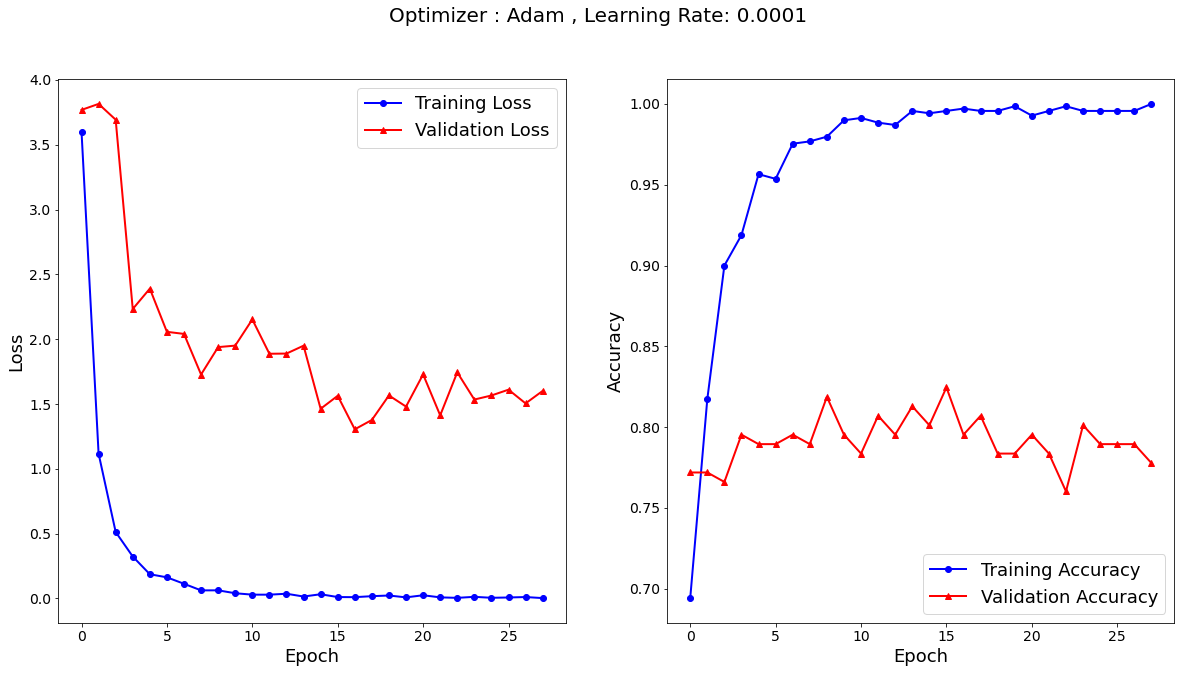

In [19]:
# Initializing the subplot 
plt.subplots(1,2,figsize=(20,10))

# Plotting the model's training and validation loss progression for every completed epoch 
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='^', color='red')

# Formatting axes and titles
plt.suptitle('Optimizer : Adam , Learning Rate: 0.0001', fontsize=20)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Formatting legend
plt.legend(loc='upper right', fontsize=18)

# Plotting the training and validation accuracy changes for every epoch 
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='^', color='red')

# Formatting axes and titles
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Formatting legend
plt.legend(loc='lower right', fontsize=18)

# Display the plots
plt.show()

## Model Evaluation 

In order to evaluate the `bestmodel`'s performance we will need to load in the `best_weights_vgg16.h5` saved by `ModelCheckpoint()`. 

In [20]:
# Saving the CNN architecture as a JSON
modelarch_json = model.to_json()
with open("rps_mb.json","w") as json_file:
    json_file.write(modelarch_json)
    
# Initialize the 'bestmodel' using the weights saved with the ModelCheckpoint callback
bestmodel = model_from_json(modelarch_json)

# Loading the weights that resulted in the best validation accuracy during training 
bestmodel.load_weights("best_weights_vgg16.h5")

# Compile the bestmodel
bestmodel.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Re-evaluating the best model's performance on the training data
train_eval = bestmodel.evaluate_generator(train_generator, steps=train_stepsize)


C:\Users\Sina\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [22]:
# Creating axis labels for future sns.heatmaps 

# Getting the class names
categories = list(train_generator.class_indices.keys())

# Preficing classes with 'Predicted ' 
predicted_labels = list('Predicted '  + category for category in categories)

# Preficing classes with 'True '
true_labels = list('True ' + category for category in categories)

# Creating labels(indices) for model evaluation metrics 
eval_metrics = list(bestmodel.metrics_names)

In [23]:
# Saving the results to a dataframe
df_train_eval = pd.DataFrame(list(train_eval), index=eval_metrics, columns=['Train'])

# Display the results
print(df_train_eval)

             Train
loss      0.025085
accuracy  0.991304


In [24]:
# Getting bestmodel's predictions (as probabilities) on the validation images 
validation_probas = bestmodel.predict_generator(validation_generator, steps=valid_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
valid_predictions = validation_probas.argmax(axis=1)

# Sanity check 
valid_predictions

C:\Users\Sina\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2,
       2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0], dtype=int64)

In [25]:
# Getting the true class labels for the validation data
valid_true = validation_generator.classes

# Sanity check 
valid_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [26]:
# Evaluating bestmodel's performance on the validation data 
valid_eval = bestmodel.evaluate_generator(validation_generator, steps=valid_stepsize)

# Saving the results to a dataframe
df_valid_eval = pd.DataFrame(list(valid_eval), index=eval_metrics, columns=['Validation'])

# Display the results 
print(df_valid_eval)

C:\Users\Sina\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
          Validation
loss        1.936321
accuracy    0.795322


In [27]:
# Displaying the classification report for the validation set
print('Validation Classification Report\n \n', classification_report(valid_true, valid_predictions, target_names=categories))

Validation Classification Report
 
               precision    recall  f1-score   support

        Mask       0.85      0.90      0.87       131
      MaskIn       0.00      0.00      0.00        11
      NoMask       0.52      0.55      0.53        29

    accuracy                           0.78       171
   macro avg       0.46      0.48      0.47       171
weighted avg       0.74      0.78      0.76       171



In [28]:
# Creating a non-normalized confusion matrix for the validation set
valid_matrix = pd.DataFrame(confusion_matrix(valid_true, valid_predictions), columns=predicted_labels, index=true_labels)

# Display the matrix
valid_matrix

,Predicted Mask,Predicted MaskIn,Predicted NoMask
True Mask,118,1,12
True MaskIn,8,0,3
True NoMask,13,0,16


<ipython-input-29-f707e88e31ca>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sns.heatmap(round(valid_matrix/valid_matrix.sum(axis=1)[:,np.newaxis],2), cmap='Blues', annot=True, linewidths=.5, linecolor='black')


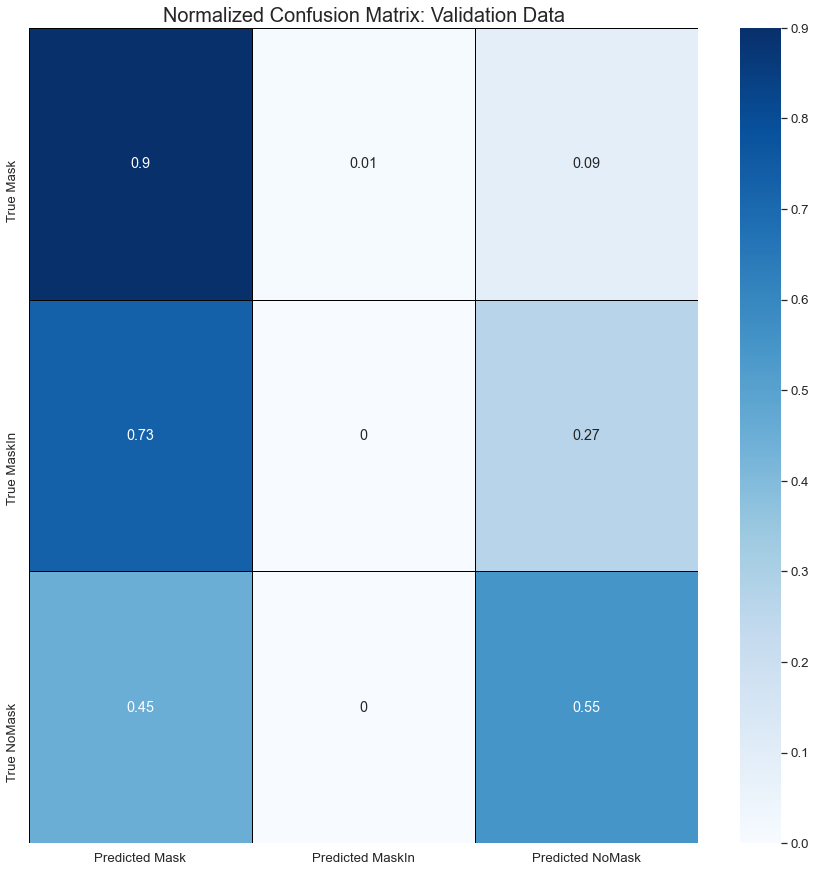

In [29]:
# Plotting the normalized confusion matrix (proportion of predictions by class) as a heatmap

# Increasing fontsize
sns.set(font_scale=1.2)

# Creating the plot
plt.figure(figsize=(15,15))
sns.heatmap(round(valid_matrix/valid_matrix.sum(axis=1)[:,np.newaxis],2), cmap='Blues', annot=True, linewidths=.5, linecolor='black')

# Formatting the title 
plt.title('Normalized Confusion Matrix: Validation Data', fontsize=20)

# Display the normalized confusion matrix
plt.show()

In [30]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas = bestmodel.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions = test_probas.argmax(axis=1)

# Sanity check 
test_predictions

C:\Users\Sina\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 0, 2, 2, 2, 2], dtype=int64)

In [31]:
# Getting the true class labels for the test set
test_true = test_generator.classes

# Sanity check 
test_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2])

In [32]:
# Evaluating the best model's performance on the test data 
test_eval = bestmodel.evaluate_generator(test_generator, steps=test_stepsize)

# Saving the results to a dataframe 
df_test_eval = pd.DataFrame(list(test_eval), index=eval_metrics, columns=['Test'])

# Display the results
print(df_test_eval)

C:\Users\Sina\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
              Test
loss      0.978966
accuracy  0.863158


In [33]:
# Displaying the classification report for the test set
print('Test Classification Report\n \n', classification_report(test_true, test_predictions, target_names=categories))

Test Classification Report
 
               precision    recall  f1-score   support

        Mask       0.93      0.97      0.95        73
      MaskIn       0.00      0.00      0.00         6
      NoMask       0.72      0.81      0.76        16

    accuracy                           0.88        95
   macro avg       0.55      0.60      0.57        95
weighted avg       0.84      0.88      0.86        95



<ipython-input-34-8573d717e44c>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sns.heatmap(round(test_matrix/test_matrix.sum(axis=1)[:,np.newaxis],2), cmap='Blues', annot=True, linewidths=.5, linecolor='black')


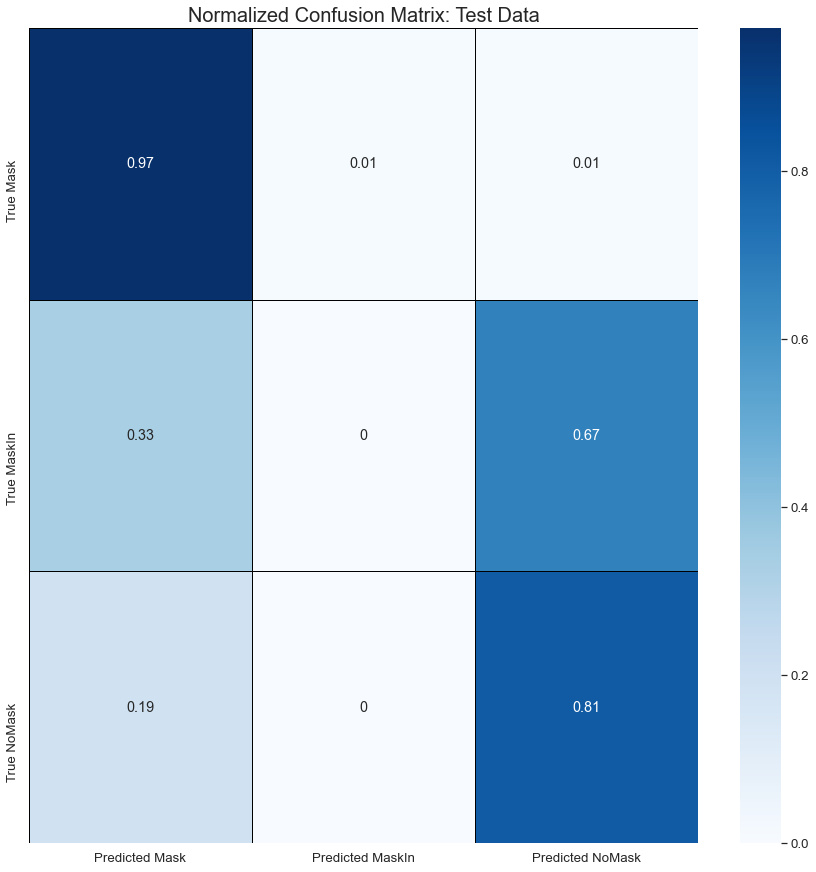

In [34]:
# Non-normalized confusion matrix for the test data
test_matrix = pd.DataFrame(confusion_matrix(test_true, test_predictions), columns=predicted_labels, index=true_labels)

# Plotting a normalized confusion matrix for the test data as a heatmap 
sns.set(font_scale=1.2)
plt.figure(figsize=(15,15))
sns.heatmap(round(test_matrix/test_matrix.sum(axis=1)[:,np.newaxis],2), cmap='Blues', annot=True, linewidths=.5, linecolor='black')
plt.title('Normalized Confusion Matrix: Test Data', fontsize=20)
plt.show()